In [1]:
#!/usr/bin/env python3
"""
Short description:
   Analyser for ACCEPT field campaign data, for detailed evaluation of Ed Luke et at. 2010 ANN approach for prediction of supercooled liquid layers in clouds
   cloud radar and polarization lidar observations.

"""

import numpy as np
import copy
import os
import sys
import time
from itertools import combinations
%matplotlib inline
import matplotlib.pyplot as plt

# disable the OpenMP warnings

PATH_TO_LARDA = '/Users/willi/code/python/larda3/larda/'
os.environ['KMP_WARNINGS'] = 'off'
sys.path.append(PATH_TO_LARDA)

import pyLARDA
import pyLARDA.helpers as h
import pyLARDA.Transformations as tr
import pyLARDA.spec2mom_limrad94 as s2m
import pyLARDA.VIS_Colormaps as colors

from utility import *
from PlottingUtility import load_xy_style
from meteoSI import mod_ad
from Utils import calc_adLWP, corr_, get_subset
import pandas as pd

import matplotlib.pyplot as plt

__author__ = "Willi Schimmel"
__copyright__ = "Copyright 2020, ACCEPT Field Campaign Analyser"
__credits__ = ["Willi Schimmel", "Heike Kalesse"]
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = "Willi Schimmel"
__email__ = "willi.schimmel@uni-leipzig.de"
__status__ = "Prototype"


cases_csv = 'accept_cases.csv'

cases = 2 # the list of cases you want to analyze

BASE_DIR = 'data/ACCEPT/timeseries/'  # path to timeseries/ folder
PLOTS_PATH = 'plots_accept/'

# choose which files to load
do_read_cloudnet_class = True
do_read_cloudnet_categ = True
do_read_polly = True
do_read_lipred = True
do_read_mira_spec_mom = False
do_read_sounding = True
do_read_GDAS1 = False

span_smoo_NNout = 0  # number of range gates for smoothing (1 = 30s)
span_smoo_MWRlwp = 20  # number of time steps for smoothing (1 = 30sec)

# {'', 'disdro', 'anydrizzle', 'rg0drizzle'} ... exclude all profiles, where the disdrometer or cloudnet classifies any or at range gate zero a pixel as drizzle
exclude_drizzle = 'rg0drizzle'

# exclude all pixels below the first cloud base detection by cloudnet
exclude_below_ceilo_cb = True

# remove x seconds after last rain flag
exclude_wet_radome_lwp = 30  # number of time steps excluded after precipitation (1 = 30sec)

# {'wrm', 'scl', 'both', 'all'} ...
# exclude all pixel except those including {warm droplets, 'super cooled droplets', 'both warm and super cooled droplets', 'include all classes'}
exclude_all_but = 'both'

# {one element of isotherm_list} ... exclude all pixels below this temperature
exclude_below_temperature = -38.0

# for good radar and lidar echos within the same sample volume, overwrite false liquid predictions
overwrite_with_valid_cloudnet = True

# number of bins that wont be considered as signal
exclude_cloud_edge_bins = 1

# threshold for relative humidity, liquid only possible for values greater than  X %
relhum_threshold = 90.0

c_lim = [1, 400] if cases == 2 else [1, 5000]
markersize = 0.25
nFoOBins = 60
N = 400
plot_target_classification = True
plot_FoO_radar = False
plot_radar_lidar = True
plot_predicted_lidar_variables = True
plot_scatter_depol_bsc = True
plot_scatter_pixel_masks = False
plot_liquid_pixel_masks = True
plot_cloudnet_mwr_lwp = True
plot_FoO = False
plot_relhum_liqpxl_overlapp = False

NC_PATH = '/Users/willi/code/python/larda3/larda/'
file_ext = '.png'
dpi  = 300



# load mat files

In [2]:
case_list = cases_from_csv(cases_csv)

# loading mat files
classification_tot = load_dot_mat_file(f'{BASE_DIR}ACCEPT_20141005-20141118_classification.mat', 'classification') if do_read_cloudnet_class else None
categorization_tot = load_dot_mat_file(f'{BASE_DIR}ACCEPT_20141005-20141118_categorization.mat', 'categorization') if do_read_cloudnet_categ else None
pollyXT_tot = load_dot_mat_file(f'{BASE_DIR}ACCEPT_20141005-20141118_polly.mat', 'PollyXT') if do_read_polly else None
hsrl_pred_tot = load_dot_mat_file(f'{BASE_DIR}ACCEPT_20141005-20141118_hsrl_prediction_30s.mat', 'HSRL prediction') if do_read_lipred else None
mira_moments_tot = load_dot_mat_file(f'{BASE_DIR}ACCEPT_20141005-20141118_moments_30s.mat', 'MIRA moments') if do_read_mira_spec_mom else None
radiosondes_tot = load_dot_mat_file(f'{BASE_DIR}ACCEPT_20141005-20141118_radiosondes_mean.mat', 'radiosondes') if do_read_sounding else None

# load range and timesteps and reshape to an 1D array
n_tot_ts_class = classification_tot['ts_class_time'].shape[0]
n_tot_rg_class = classification_tot['h_class'].shape[0]
cloudnet_dn = classification_tot['ts_class_time'].reshape((n_tot_ts_class,))
cloudnet_dt = np.array([datenum2datetime(ts) for ts in cloudnet_dn])
cloudnet_rg = classification_tot['h_class'].reshape((n_tot_rg_class,))

# slice to begin_dt - end_dt

In [3]:
case = case_list[cases]

begin_dt, end_dt = case['begin_dt'], case['end_dt']

# create directory for plots
h.change_dir(f'{PLOTS_PATH}case_study_{begin_dt:%Y%m%d%H%M%S}-{end_dt:%Y%m%d%H%M%S}/')
logging.basicConfig(filename=f'case_study_{begin_dt:%Y%m%d%H%M%S}-{end_dt:%Y%m%d%H%M%S}.log', level=logging.INFO)

# find indices for slicing
rg0val, rgNval = case['plot_range']
rg0idx, rgNidx = h.argnearest(cloudnet_rg, rg0val), h.argnearest(cloudnet_rg, rgNval)
rgN = rgNidx - rg0idx
rg_case = cloudnet_rg[rg0idx:rgNidx]

ts0val, tsNval = datetime2datenum(begin_dt), datetime2datenum(end_dt)
ts0idx, tsNidx = h.argnearest(cloudnet_dn, ts0val), h.argnearest(cloudnet_dn, tsNval)
tsN = tsNidx - ts0idx
dt_case = cloudnet_dt[ts0idx:tsNidx]

assert tsN * rgN > 0, ValueError('Error occurred! Number of time steps or range bins invalid, check rgN and tsN!')

ts_smth = '_smoothed' if span_smoo_MWRlwp > 0 else ''

In [4]:
classification = time_height_slicer(classification_tot, [ts0idx, tsNidx], [rg0idx, rgNidx]) if do_read_cloudnet_class else None
categorization = time_height_slicer(categorization_tot, [ts0idx, tsNidx], [rg0idx, rgNidx]) if do_read_cloudnet_categ else None
pollyXT = time_height_slicer(pollyXT_tot, [ts0idx, tsNidx], [rg0idx, rgNidx]) if do_read_polly else None
hsrl_pred = time_height_slicer(hsrl_pred_tot, [ts0idx, tsNidx], [rg0idx, rgNidx]) if do_read_lipred else None
mira_moments = time_height_slicer(mira_moments_tot, [ts0idx, tsNidx], [rg0idx, rgNidx]) if do_read_mira_spec_mom else None
radiosondes = time_height_slicer(radiosondes_tot, [ts0idx, tsNidx], [rg0idx, rgNidx]) if do_read_sounding else None

T = tr.combine(toC, [wrapper(categorization, var_name='T_mod_ts', var_unit='C', var_lims=[-50, 20])], {'var_unit': "C"})
contour = {'data': T, 'levels': isotherm_list}

RH = tr.combine(toC, [wrapper(categorization, var_name='rh_mod_ts', var_unit='%', var_lims=[80, 100])], {'var_unit': "%"})
contour_rh = {'data': RH, 'levels': np.arange(90, 100, 10)}

# add indices of first cloud base to classification dict
classification.update({'first_cb_idx': get_1st_cloud_base_idx(classification['cb_first_ts'], cloudnet_rg)})

# extract isotherm lines, indices, temperatures at index and range at index
isotherm_lines = {f'{iTemp}degC': get_temp_lines(categorization['T_mod_ts'], cloudnet_rg, iTemp) for iTemp in isotherm_list}

# assuming this works with nan values
# span = number of data points used for smoothing of ANN BSC + depol before liquid mask creation; here: 5 profiles at 30s resolution = 2.5min
if rgN > span_smoo_NNout > 0:
    for iH in range(rgN):
        hsrl_pred['bsc_NN_ts'][iH, :] = h.smooth(hsrl_pred['bsc_NN_ts'][iH, :], span_smoo_NNout)
        hsrl_pred['CDR_NN_ts'][iH, :] = h.smooth(hsrl_pred['CDR_NN_ts'][iH, :], span_smoo_NNout)
        hsrl_pred['dpol_NN_ts'][iH, :] = h.smooth(hsrl_pred['dpol_NN_ts'][iH, :], span_smoo_NNout)

# number of data points (profiles) used for smoothing time series data of MWR-LWP and predicted liquid layer thickness;
if tsN > span_smoo_MWRlwp > 0:
    categorization.update({'lwp_ts_smoothed': np.ma.masked_less_equal(h.smooth(categorization['lwp_ts'], span_smoo_MWRlwp), 0.0)})

_ = np.ma.masked_invalid(categorization[f"lwp_ts{ts_smth}"])
categorization.update({'ts_lwp_mask': ~np.ma.getmask(_)})

""" 
categories: see cloudnet target classification 1 = cloud droplets only, ..., 10 = aerosol + insects

cloudnet_liq_mask % combination of all Cloudnet classes containing only scl (excluding rain and scl below -38°C)
combi_liq_mask    % masks filtered below isotherms where 0=no liquid, 1=ann and cloudnet detecting liquid, 2=ann only, 3=cloudnet only

Caution! Warnings for invalid values disabled!
"""
# extract cloudnet target classification categories
categories = [classification['target_class_ts'] == iclass for iclass in range(1, 11)]
categories.insert(0, 'not-a-category')

# initialize the (range, time) liquid mask for cloudnet
target_labels = classification['target_class_ts'].copy()
detection_status = classification['detect_status_ts'].copy()
cloudnet_liq_mask = np.full((rgN, tsN), False)
idx_cloudnet_liquid = categories[1] + categories[3] + categories[5] + categories[7]
cloudnet_liq_mask[idx_cloudnet_liquid] = True
# cloudnet_liq_mask[detection_status == 1] = False    # remove lidar echos only

# exctract different rain flags, ignore invalid value warnings
with np.errstate(invalid='ignore'):
    rain_flag = {'disdro': categorization['rainrate_ts'] > 0.0,
                 'anydrizzle': categories[2].any(axis=0),
                 'rg0drizzle': categories[2][0, :].copy()}

# exclude a number of time steps after precipitation (wet radome)
if exclude_wet_radome_lwp > 0 and exclude_drizzle in ['disdro', 'anydrizzle', 'rg0drizzle']:
    for iT in range(tsN - exclude_wet_radome_lwp, -1, -1):
        if rain_flag[exclude_drizzle][iT] == 1:
            categorization['ts_lwp_mask'][iT:iT + exclude_wet_radome_lwp] = False

if exclude_cloud_edge_bins > 0:
    # plot the cloud contours minus 2 pixel around the clouds
    liq_contour = remove_cloud_edges((~cloudnet_liq_mask).T * 1, n=exclude_cloud_edge_bins)
    liq_contour = s2m.despeckle(liq_contour * 1, 80)
else:
    liq_contour = (~cloudnet_liq_mask).T * 1
cbct_list_cn, cbct_mask_cn = find_bases_tops(liq_contour, rg_case)

In [5]:
logger.info(f'******************BEGIN CASE STUDY******************\n')
logger.info(f'Slicing time from {begin_dt:%Y-%m-%d %H:%M:%S} (UTC) to {end_dt:%Y-%m-%d %H:%M:%S} (UTC)')
logger.info(f'Slicing range from {rg0val:.2f} (km) to {rgNval:.2f} (km)\n')
logger.info(f'Global parameter settings:')
logger.info(f'  Smoothing:')
logger.info(f'      - smooth ANN output = {span_smoo_NNout > 0},    span_smoo_NNout  = {span_smoo_NNout} (1=30m)')
logger.info(f'      - smooth MWR LWP   = {span_smoo_MWRlwp > 0},    span_smoo_MWRlwp = {span_smoo_MWRlwp} (1=30sec)')
logger.info(f'  Excluding data:')
logger.info(f'      - exclude_drizzle           = {exclude_drizzle}')
logger.info(f'      - exclude_below_ceilo_cb    = {exclude_below_ceilo_cb}')
logger.info(f'      - exclude_wet_radome_lwp    = {exclude_wet_radome_lwp} (1=30sec)')
logger.info(f'      - exclude_all_but           = {exclude_all_but} [liquid pixel]')
logger.info(f'      - exclude_below_temperature = {int(exclude_below_temperature)} [degC]')
logger.info(f'      - exclude_cloud_edge_bins   = {int(exclude_cloud_edge_bins)}')
logger.info(f'  Thresholds:')
logger.info(f'      - relhum_threshold          = {relhum_threshold}\n')

# plotting outside of the lidar threshold loop
logger.info('')
logger.info('Plotting radar moments, lidar variables, lwp, etc.:')
Ze_dict = wrapper(categorization, var_name='Ze_cc_ts', var_unit='dBZ', var_lims=[-60, 20])
VEL_dict = wrapper(categorization, var_name='Vd_cc_ts', var_unit='m s-1', var_lims=[-6, 2])
sw_dict = wrapper(categorization, var_name='width_cc_ts', var_unit='m s-1', var_lims=[0, 1])
ldr_dict = wrapper(categorization, var_name='ldr_cc_ts', var_unit='dB', var_lims=[-30, 0])
attbsc_dict = wrapper(pollyXT, var_name='bsc_polly_ts', var_unit='m-1 sr-1', var_lims=[1.e-7, 1.e-4])
depol_dict = wrapper(pollyXT, var_name='dpol_polly_ts', var_unit='%', var_lims=[0.0, 0.2])
dt_list = [h.ts_to_dt(ts) for ts in Ze_dict['ts']]

pred_bsc = wrapper(hsrl_pred, var_name='bsc_NN_ts', var_unit='log(sr-1 m-1)', var_lims=variable_dict['bsc_NN_ts'][1])
pred_dpl = wrapper(hsrl_pred, var_name='dpol_NN_ts', var_unit='1', var_lims=variable_dict['dpol_NN_ts'][1])
pred_cdr = wrapper(hsrl_pred, var_name='CDR_NN_ts', var_unit='log(left/right)', var_lims=variable_dict['CDR_NN_ts'][1])

Range_dict = copy.deepcopy(Ze_dict)
Range_dict['var'] = np.transpose(np.repeat(Range_dict['rg'][:, np.newaxis], Range_dict['ts'].shape, axis=1))
Range_dict['var_unit'] = 'km'
Range_dict['name'] = 'range'
Range_dict['var_lims'] = [0, 12]
time_string = f'{begin_dt:%Y%m%d%H%M%S}-{end_dt:%Y%m%d%H%M%S}'

plot_radar_lidar = False
if plot_radar_lidar:
    fig_p, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 16))
    plot_specs.update({'fig': fig_p, 'zlabel': '', 'contour': contour, 'font_size': 15})
    _, ax[0] = tr.plot_timeheight(Ze_dict, title=f'reflectivity [dBZ]', ax=ax[0], zlim=[-60, 20], **plot_specs)
    _, ax[1] = tr.plot_timeheight(VEL_dict, title=r'mean Doppler velocty [m s$^{-1}$]', ax=ax[1], zlim=[-4, 2], **plot_specs)
    _, ax[2] = tr.plot_timeheight(sw_dict, title=r'spectrum width [m s$^{-1}$]', ax=ax[2], zlim=[1.e-2, 1], z_converter='log', **plot_specs)
    _, ax[3] = tr.plot_timeheight(attbsc_dict, title=r'attenuated backscatter @532 nm [m$^{-1}$ s$^{-1}$]', ax=ax[3], zlim=[1.e-7, 1.e-3],
                                  z_converter='log', **plot_specs)
    _, ax[4] = tr.plot_timeheight(depol_dict, title=f'linear volume depolarization [1]', ax=ax[4], zlim=[0, 0.2], **plot_specs)

    for j in range(4):
        ax[j].set_xlabel('')

    fig_p.subplots_adjust(hspace=0.375)
    fig_p.tight_layout()
    fig_p.savefig(f'{time_string}-Cloudnet_radar_lidar_ACCEPT{file_ext}', dpi=dpi)



******************BEGIN CASE STUDY******************

Slicing time from 2014-11-16 23:59:00 (UTC) to 2014-11-18 13:31:00 (UTC)
Slicing range from 0.00 (km) to 10.00 (km)

Global parameter settings:
  Smoothing:
      - smooth ANN output = False,    span_smoo_NNout  = 0 (1=30m)
      - smooth MWR LWP   = True,    span_smoo_MWRlwp = 20 (1=30sec)
  Excluding data:
      - exclude_drizzle           = rg0drizzle
      - exclude_below_ceilo_cb    = True
      - exclude_wet_radome_lwp    = 30 (1=30sec)
      - exclude_all_but           = both [liquid pixel]
      - exclude_below_temperature = -38 [degC]
      - exclude_cloud_edge_bins   = 1
  Thresholds:
      - relhum_threshold          = 90.0


Plotting radar moments, lidar variables, lwp, etc.:


In [6]:
plot_target_classification = False
if plot_target_classification:
    fig_name = f'CLASS_{time_string}_ACCEPT{file_ext}'
    target_class_container = wrapper(classification, fig_size=(10, 16/5), var_name='target_class_ts', var_unit='-')
    fig, ax = tr.plot_timeheight(target_class_container, range_interval=case['plot_range'], cbar_label=False, **plot_specs)
    # ax.contour(dt_case, rg_case, liq_contour.T, linestyles='-', colors='black', linewidths=0.75)
    # ax.scatter(dt_case, classification['cb_first_ts'])
    fig.savefig(fig_name, dpi=dpi)
    logger.info(f'Figure saved :: {fig_name}')

0
1
2


Figure saved :: FoO-ANN-dpl-vs-bsc_20141116235900-20141118133100_ACCEPT_excl-all-but-both.png


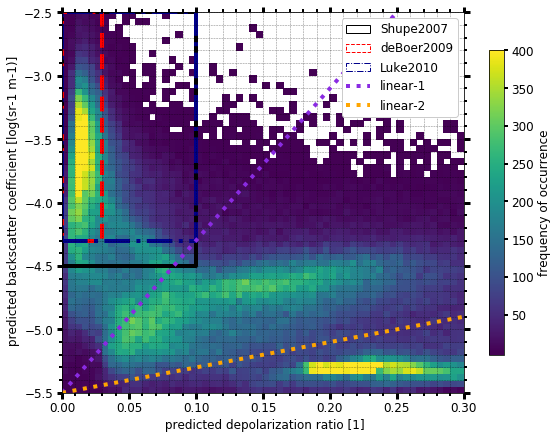

In [8]:
plot_scatter_depol_bsc = True
if plot_scatter_depol_bsc:
    titlestring = f'ACCEPT -- FoO predicted linear depolarization vs. attenuated backscatter\n' \
                  f'date: {begin_dt:%Y-%m-%d - %H:%M} till {end_dt:%Y-%m-%d - %H:%M} [UTC]'

    pred_bsc['name'] = 'predicted backscatter coefficient'
    pred_dpl['name'] = 'predicted depolarization ratio'

    if exclude_all_but in liq_mask_flags:
        _combi_mask = (target_labels == 8) + (target_labels == 9) + (target_labels == 10)

        pred_dpl['mask'][_combi_mask.T] = True
        pred_bsc['mask'][_combi_mask.T] = True

    plot_specs.update({'fig_size': (7, 7)})
    fig, ax = tr.plot_scatter(pred_dpl, pred_bsc,
                              x_lim=variable_dict['dpol_NN_ts'][1],
                              y_lim=variable_dict['bsc_NN_ts'][1],
                              # title=titlestring,
                              colorbar=True,
                              scale='lin',
                              Nbins=nFoOBins, c_lim=c_lim,
                              **plot_specs)
    ax = add_boxes(ax, {**lidar_thresh_dict, **lidar_thresh_dict_other}, **{'size': 12, 'weight': 'normal'})
    #ax = add_boxes(ax, lidar_thresh_dict_other, **{'size': 10, 'weight': 'normal'})
    fig_name = f'FoO-ANN-dpl-vs-bsc_{time_string}_ACCEPT_excl-all-but-{exclude_all_but}{file_ext}'
    fig.savefig(fig_name, dpi=dpi)
    logger.info(f'Figure saved :: {fig_name}')


    
plot_specs.update({'fig_size': (12, 5)})


/Users/willi/code/python/local_stuff/voodoo_quicklooks/utility.py:274: RuntimeWarning: invalid value encountered in greater
  low_depol, high_depol  = dpl_xaxis[iBin] > hsrl_pred['dpol_NN_ts'], dpl_xaxis[iBin] < hsrl_pred['dpol_NN_ts']
/Users/willi/code/python/local_stuff/voodoo_quicklooks/utility.py:274: RuntimeWarning: invalid value encountered in less
  low_depol, high_depol  = dpl_xaxis[iBin] > hsrl_pred['dpol_NN_ts'], dpl_xaxis[iBin] < hsrl_pred['dpol_NN_ts']
/Users/willi/code/python/local_stuff/voodoo_quicklooks/utility.py:276: RuntimeWarning: invalid value encountered in greater
  low_bsc1, high_bsc1  = bsc1_yaxis[iBin] > hsrl_pred['bsc_NN_ts'], bsc1_yaxis[iBin] < hsrl_pred['bsc_NN_ts']
/Users/willi/code/python/local_stuff/voodoo_quicklooks/utility.py:276: RuntimeWarning: invalid value encountered in less
  low_bsc1, high_bsc1  = bsc1_yaxis[iBin] > hsrl_pred['bsc_NN_ts'], bsc1_yaxis[iBin] < hsrl_pred['bsc_NN_ts']
/Users/willi/code/python/local_stuff/voodoo_quicklooks/utility.py:

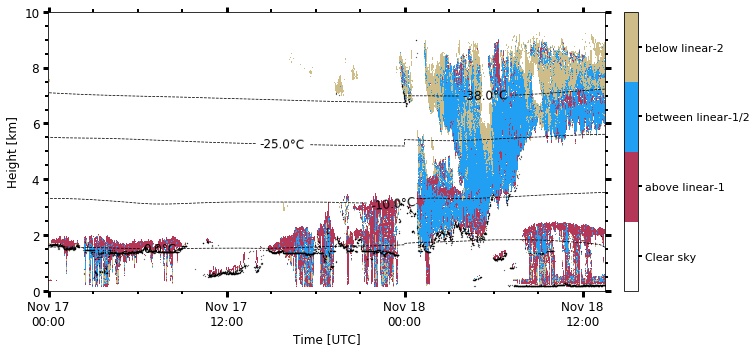

In [9]:
plot_scatter_pixel_masks = True
if plot_scatter_pixel_masks:
    fig_name = f'SCATTER-MASK_{time_string}_{exclude_drizzle}_ACCEPT{file_ext}'

    classification.update({'combi_scatter_mask': get_combined_scatter_mask(hsrl_pred, nFoOBins)})

    combi_scatter_mask = wrapper(classification, var_name='combi_scatter_mask', var_unit='-')
    combi_scatter_mask['var_name'] = 'combi_scatter_mask'
    tmp_fZ = np.array(plot_specs['fig_size'])
    plot_specs['fig_size'] = [10, 5]

    fig, ax = tr.plot_timeheight(combi_scatter_mask, range_interval=case['plot_range'], contour=contour, zlabel='', **plot_specs)
    # add the first cloud base, as observed by the lidar
    ax.scatter(dt_case, classification['cb_first_ts'], color='black', marker='.', s=markersize)
    fig.savefig(fig_name, dpi=dpi)
    logger.info(f'Figure saved :: {fig_name}')
    plot_specs['fig_size'] = tmp_fZ


In [10]:
plot_predicted_lidar_variables = False
# plotting inside the lidar threshold loop
if plot_predicted_lidar_variables:
    fig_name = f'NN-hsrl-bsc_{time_string}_ACCEPT_smth-{str(span_smoo_NNout)}{file_ext}'
    pred_bsc['var'] = np.power(10.0, pred_bsc['var'])
    pred_bsc['var_lims'] = [1.e-7, 1.e-3]
    pred_bsc['var_unit'] = 'sr-1 m-1'

    fig, _ = tr.plot_timeheight(pred_bsc, range_interval=case['plot_range'], var_converter='log',  **plot_specs)
    # ax.contour(dt_case, rg_case, ann_liquid_mask, linestyles='-', colors='black', linewidths=1.75)
    fig.savefig(fig_name, dpi=Ndpi)
    logger.info(f'Figure saved :: {fig_name}')

    pred_dpl['var_lims'] = [0.0, 0.2]
    fig_name = f'NN-hsrl-dpl_{time_string}_ACCEPT_smth-{str(span_smoo_NNout)}{file_ext}'
    fig, _ = tr.plot_timeheight(pred_dpl, range_interval=case['plot_range'],  **plot_specs)
    # ax.contour(dt_case, rg_case, ann_liquid_mask, linestyles='-', colors='black', linewidths=1.75)
    fig.savefig(fig_name, dpi=dpi)
    logger.info(f'Figure saved :: {fig_name}')


In [11]:
def _get_liqudi_mask(ithresh_name, ithresh_val, bsc, dpl):
    """
        ann_liq_mask    % (range, time) liquid mask where True == liquid, False == non-liquid, depends on the selected threshold box/linfcn
        Caution! Warnings for invalid values disabled!
    """
    # derive liquid water mask using different box-thresholds
    liquid_mask = np.full(bsc.shape, False)
    print(ithresh_name)
    if 'linear' in ithresh_name:
        dpl_xaxis = np.linspace(0, 0.3, nFoOBins).astype(np.float32)
        bsc_yaxis = ithresh_val['slope'] * dpl_xaxis + ithresh_val['intersection']

        for iBin in range(nFoOBins):
            high_backscatter = bsc > bsc_yaxis[iBin]
            low_depolarization = dpl < dpl_xaxis[iBin]
            liquid_mask[high_backscatter * low_depolarization] = True

        logger.info(f'Threshold for liquid classification added: {ithresh_name} with slope = {ithresh_val["slope"]:.2f} and intersection = ' 
                    f'{ithresh_val["intersection"]:.2f}')
    else:
        with np.errstate(invalid='ignore'):
            high_backscatter = bsc > ithresh_val['bsc']
            low_depolarization = dpl < ithresh_val['dpl']
            liquid_mask[high_backscatter * low_depolarization] = True

        logger.info(f'Threshold for liquid classification added: {ithresh_name} - att. bsc. > {ithresh_val["bsc"]:.2e} - lin. vol. depol < {ithresh_val["dpl"]:.2e} - ')
                    
    return liquid_mask

# Define lidar threshold and extract liquid masks

In [12]:
np.warnings.filterwarnings('ignore')
lidar_thresh_dict = {
    
    'Shupe2007': {
        'bsc': -4.5, 
        'dpl': 0.1, 
        'cdr': -6.532125137753436e-01
    },
    
    'deBoer2009': {
        'bsc': -4.3, 
        'dpl': 0.03, 
        'cdr': -1.208620483882601e+00
    },
    
    'Luke2010': {
        'bsc': -4.3, 
        'dpl': 0.1, 
        'cdr': -7.422612476299660e-01
    },
    
    'linear-1': {
        'slope': 12.0, 
        'intersection': -5.5
    },
    
    'linear-2': {
        'slope': 2.0, 
        'intersection': -5.5
    },
    
    'cloudnet-lidar': {
        'bsc': -4.7, 
        'dpl': 1.0, 
    },
    
}

# initialize combined (range, time) liquid mask, containing all detected liquid pixels
cloudnet_thresh_dict = {'liquid_mask': cloudnet_liq_mask.copy()}

for ithresh_name, ithresh_val in lidar_thresh_dict.items():
    lidar_thresh_dict[ithresh_name].update({
        'liquid_mask': _get_liqudi_mask(ithresh_name, ithresh_val, hsrl_pred['bsc_NN_ts'], hsrl_pred['dpol_NN_ts'])
    })
    
for ithresh_name, ithresh_val in lidar_thresh_dict.items():
    lidar_thresh_dict[ithresh_name].update({
        'combi_liquid_mask': get_combined_liquid_mask(lidar_thresh_dict[ithresh_name]['liquid_mask'], cloudnet_thresh_dict['liquid_mask'])
    })
    
#cloudnet_thresh_dict.update({
#        'combi_liquid_mask': get_combined_liquid_mask(lidar_thresh_dict[ithresh_name]['liquid_mask'], lidar_thresh_dict['cloudnet']['liquid_mask'])
#})




Threshold for liquid classification added: Shupe2007 - att. bsc. > -4.50e+00 - lin. vol. depol < 1.00e-01 - 
Threshold for liquid classification added: deBoer2009 - att. bsc. > -4.30e+00 - lin. vol. depol < 3.00e-02 - 
Threshold for liquid classification added: Luke2010 - att. bsc. > -4.30e+00 - lin. vol. depol < 1.00e-01 - 


Shupe2007
deBoer2009
Luke2010
linear-1


Threshold for liquid classification added: linear-1 with slope = 12.00 and intersection = -5.50


linear-2


Threshold for liquid classification added: linear-2 with slope = 2.00 and intersection = -5.50
Threshold for liquid classification added: cloudnet-lidar - att. bsc. > -4.70e+00 - lin. vol. depol < 1.00e+00 - 


cloudnet-lidar


# *********************************************
# EXCLUDE UNWANTED PIXEL

In [13]:

for ithresh_name, ithresh_val in lidar_thresh_dict.items():

    new_mask = lidar_thresh_dict[ithresh_name]['liquid_mask'].copy()
    
    # remove drizzle/rain profiles from all masks
    if exclude_drizzle in ['disdro', 'anydrizzle', 'rg0drizzle']:
        new_mask[:, rain_flag[exclude_drizzle]] = False
        
    if exclude_wet_radome_lwp > 0:
        for iT in range(tsN - exclude_wet_radome_lwp, -1, -1):
            if rain_flag[exclude_drizzle][iT]:
                new_mask[:, iT:iT + exclude_wet_radome_lwp] = False    

    # remove all pxl below ceilo base (rain!)
    if exclude_below_ceilo_cb:
        for iT in range(tsN):
            idx = int(classification['first_cb_idx'][iT]) if not np.isnan(classification['first_cb_idx'][iT]) else 0
            new_mask[:idx, iT] = False
            
    # remove all pxl below a certain temperature
    if exclude_below_temperature in isotherm_list:
        new_mask[lidar_thresh_dict[ithresh_name]['combi_liquid_mask'] == 0] = False

    # remove the outer N layers arround a cloud
    if exclude_cloud_edge_bins > 0:
        new_mask = s2m.despeckle(remove_cloud_edges(new_mask * 1, n=exclude_cloud_edge_bins) * 1, 80)

    # use overwrite with valid cloudnet information
    if overwrite_with_valid_cloudnet:
        new_mask[(detection_status == 3) * (lidar_thresh_dict[ithresh_name]['combi_liquid_mask'] == 2)] = 0
        
    lidar_thresh_dict[ithresh_name]['liquid_mask'] = new_mask
    lidar_thresh_dict[ithresh_name]['combi_liquid_mask'][new_mask] = 0
        

In [14]:
def add_ll_thichkness(ax, dt_list, sum_ll_thickness, **kwargs):
    font_size = kwargs['font_size'] if 'font_size' in kwargs else 15
    font_weight = kwargs['font_weight'] if 'font_weight' in kwargs else 'semibold'
    y_lim = kwargs['y_lim'] if 'y_lim' in kwargs else [0, 2]
    smooth = kwargs['smooth'] if 'smooth' in kwargs else False
    cn_varname = 'cloudnet_smoothed' if smooth else 'cloudnet'
    nn_varname = 'neuralnet_smoothed' if smooth else 'neuralnet'

    ax1 = ax.twinx()
    ax1.plot(dt_list, sum_ll_thickness, color='black', linestyle='-', alpha=0.75, label=cn_varname)
    ax1.plot(dt_list, sum_ll_thickness, color='red', linestyle='-', alpha=0.75, label=nn_varname)

    ax1.set_ylim(y_lim)
    ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax1.tick_params(axis='both', which='both', right=True)
    ax1.tick_params(axis='both', which='major', labelsize=font_size, width=3, length=5.5)
    ax1.tick_params(axis='both', which='minor', width=2, length=3)
    ax1 = tr.set_xticks_and_xlabels(ax1, dt_list[-1] - dt_list[0])
    ax1.set_ylabel('liquid layer thickness [m]', fontsize=font_size, fontweight=font_weight)

    return ax1

In [15]:
def add_contour(ax, dt, rg, contour, fontsize=12, **kwargs):

    assert len(contour) > 1, 'Contour data empty!'

    if 'levels' in kwargs:
        cont = ax.contour(dt, rg, contour.T,
                          kwargs['levels'],
                          linestyles='dashed', colors='black', linewidths=0.75
                          )
    else:
        cont = ax.contour(dt, rg, contour.T,
                          linestyles='dashed', colors='black', linewidths=0.75)

    ax.clabel(cont, fontsize=fontsize, inline=1, fmt='%1.1f°C', )
    return cont

Figure saved :: ALL-LIQ-MASK_20141116235900-20141118133100_rg0drizzle_ACCEPT.png


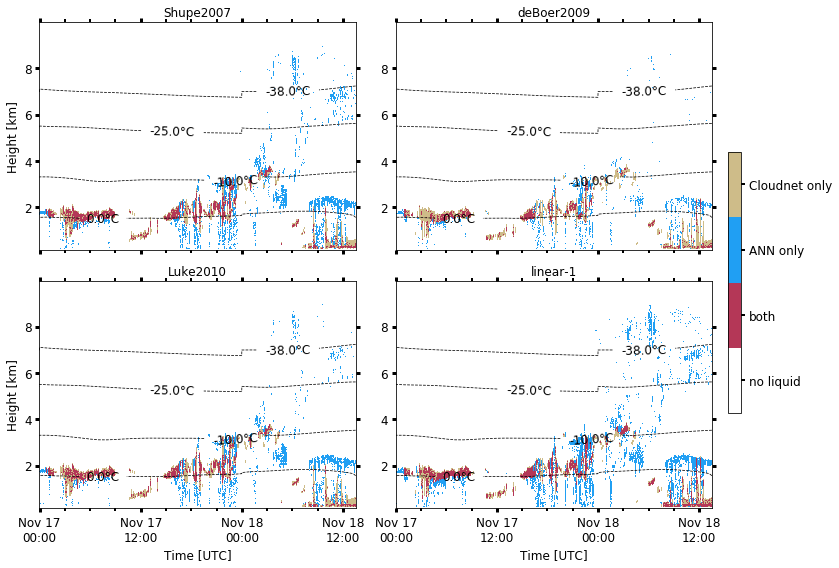

In [16]:
from itertools import product
from PlottingUtility import load_cbar_style
cn_liq_mask = cloudnet_thresh_dict['liquid_mask']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plot_specs.update({'fig': fig})
indices = np.arange(4).reshape((2, 2))

time_extend = dt_list[-1] - dt_list[0]

# loop over the different box thresholds
for (i, j), (ithresh_name, ithresh_val) in zip(product(range(2), range(2)), lidar_thresh_dict.items()):
    
    # calculate layer thickness for all different categories
    combi_liq_mask = lidar_thresh_dict[ithresh_name]['combi_liquid_mask']
    classification.update({'combi_liq_mask': combi_liq_mask})
    combi_liquid_mask = wrapper(classification, var_name='combi_liq_mask', var_unit='-')
    
    plot_specs.update({'zlim': [0.0, 4.0], 'cbar_label': False})

    pcmesh = ax[i,j].pcolormesh(dt_list, combi_liquid_mask['rg'], combi_liquid_mask['var'].T, cmap=colors.four_color_map, vmin=0, vmax=4, label=f'{ithresh_name}')
    
    cont = add_contour(ax[i, j], dt_list, combi_liquid_mask['rg'], contour['data']['var'], levels=contour['levels'])
    
    load_xy_style(ax[i, j], ylabel='Height [km]')
    ax[i, j] = tr.set_xticks_and_xlabels(ax[i, j], time_extend)
    ax[i, j].set_title(f'{ithresh_name}')
   
    if j == 1: 
        ax[i, j].set_ylabel('')
#        ax[i, j].set_yticklabels([])
    if i < 1: 
        ax[i, j].set_xlabel('')
        ax[i, j].set_xticklabels([])
            

cbar = fig.colorbar(pcmesh, ax=ax[:, 1:], pad=0.5,  shrink=0.6)

load_cbar_style(cbar)
cbar.set_ticks(list(np.arange(0.5, len(colors.categories["four_colors"])+1)))
cbar.ax.set_yticklabels(colors.categories["four_colors"]) 
        
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.tight_layout(rect=[0, 0, 0.85, 1.])

fig_name = f'ALL-LIQ-MASK_{time_string}_{exclude_drizzle}_ACCEPT{file_ext}'
fig.savefig(fig_name, dpi=dpi)
logger.info(f'Figure saved :: {fig_name}')

In [17]:
corr_coefs = {}
rg_res=30.0
cn_sum_ll_thickness = np.count_nonzero(cloudnet_thresh_dict['liquid_mask'], axis=0)*rg_res
sum_cn_ll_thickness_smoothed = h.smooth(cn_sum_ll_thickness, span_smoo_MWRlwp)


# loop over the different box thresholds
for (i, j), (ithresh_name, ithresh_val) in zip(product(range(2), range(2)), lidar_thresh_dict.items()):
        
    # calculate layer thickness for all different categories
    liq_mask = lidar_thresh_dict[ithresh_name]['liquid_mask']
    combi_liq_mask = lidar_thresh_dict[ithresh_name]['combi_liquid_mask']
    classification.update({'combi_liq_mask': combi_liq_mask})
    combi_liquid_mask = wrapper(classification, var_name='combi_liq_mask', var_unit='-')
    
    
    sum_ll_thickness = np.count_nonzero(liq_mask, axis=0)*rg_res
    
    # add smoothed liquid layer thickness
    if span_smoo_MWRlwp > 0:
        sum_ll_thickness_smoothed = h.smooth(sum_ll_thickness, span_smoo_MWRlwp)


    # count amount of liquid pixels for each combination
    key, val = np.unique(combi_liq_mask, return_counts=True)
    combi_mask_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    combi_mask_counts.update(zip(key, val))
    
    tot_nnz = np.count_nonzero(lidar_thresh_dict[ithresh_name]['combi_liquid_mask'])
    logger.info(f'nr. of pxl where Cloudnet and/or ANN classify liquid after  aerosol/insect removal  : {tot_nnz}')

    logger.info('\n----- (comparison of amount of pxl classified as liquid by Cloudnet or ANN output) --------')
    logger.info(f'overlapping pxl where ANN + Cloudnet detected liquid : {combi_mask_counts[1] * 100 / tot_nnz:.2f} %')
    logger.info(f'overlapping pxl where ONLY ANN predicts liquid       : {combi_mask_counts[2] * 100 / tot_nnz:.2f} %')
    logger.info(f'overlapping pxl where ONLY Cloudnet detected liquid : {combi_mask_counts[3] * 100 / tot_nnz:.2f} %\n')

    joined_lwp_llt_both = (categorization['ts_lwp_mask']) * (cn_sum_ll_thickness > 0.0) * (sum_ll_thickness > 0.0)

    cbct_list_cn, cbct_mask_cn = find_bases_tops((~cloudnet_liq_mask).T * 1, rg_case)
    cbct_list_nn, cbct_mask_nn = find_bases_tops((~liq_mask).T * 1, rg_case)
    cb_nn, cb_cn = np.full(len(dt_case), np.nan), np.full(len(dt_case), np.nan)
    for iT in range(len(dt_case)):
        idx_cn, idx_nn = np.argwhere(cbct_mask_cn[iT, :] == -1), np.argwhere(cbct_mask_nn[iT, :] == -1)
        cb_cn[iT] = rg_case[int(idx_cn[0])] if len(idx_cn) > 0 else 0.0
        cb_nn[iT] = rg_case[int(idx_nn[0])] if len(idx_nn) > 0 else 0.0

    joined_cb_both = (np.nan_to_num(classification['cb_first_ts']) > 0.0) * (cb_cn > 0.0) * (cb_nn > 0.0)

    if exclude_drizzle in ['disdro', 'anydrizzle', 'rg0drizzle'] and exclude_wet_radome_lwp > 0:
        joined_lwp_llt_both[rain_flag[exclude_drizzle]] = False
        joined_cb_both[rain_flag[exclude_drizzle]] = False

    cb_cn, cb_nn = np.ma.masked_less_equal(cb_cn, 0.0), np.ma.masked_less_equal(cb_nn, 0.0)

    # wrap lwp and exclude drizzle from statistic
    mask_lwp = True
    lwp = wrapper(categorization, var_name=f'lwp_ts{ts_smth}', var_unit='g m-2', var_lims=[0, 250])
    if mask_lwp:
        lwp['var'][rain_flag[exclude_drizzle]] = -1
        sum_ll_thickness[rain_flag[exclude_drizzle]] = -1
        sum_ll_thickness = np.ma.masked_less_equal(sum_ll_thickness, 0)

        lwp['var'] = np.ma.masked_invalid(lwp['var'])

    corr_coefs.update({
        ithresh_name: {
            f'lwp-llt': corr_(categorization[f"lwp_ts"][joined_lwp_llt_both], sum_ll_thickness[joined_lwp_llt_both]),
            f'lwp-llt_s': corr_(categorization[f"lwp_ts{ts_smth}"][joined_lwp_llt_both], sum_ll_thickness_smoothed[joined_lwp_llt_both]),
            f'cbh-llh': corr_(classification["cb_first_ts"][joined_cb_both], cb_nn[joined_cb_both])
        }
    })

    lidar_thresh_dict[ithresh_name]['sum_ll_thickness'] = sum_ll_thickness
    lidar_thresh_dict[ithresh_name]['sum_ll_thickness_smoothed'] = sum_ll_thickness_smoothed

corr_coefs.update({
    'cloudnet': {
        f'lwp-llt': corr_(categorization[f"lwp_ts"][joined_lwp_llt_both], sum_ll_thickness[joined_lwp_llt_both]),
        f'lwp-llt_s': corr_(categorization[f"lwp_ts{ts_smth}"][joined_lwp_llt_both], sum_ll_thickness_smoothed[joined_lwp_llt_both]),
        f'cbh-llh': corr_(classification["cb_first_ts"][joined_cb_both], cb_cn[joined_cb_both]),
    }
})                

nr. of pxl where Cloudnet and/or ANN classify liquid after  aerosol/insect removal  : 92848

----- (comparison of amount of pxl classified as liquid by Cloudnet or ANN output) --------
overlapping pxl where ANN + Cloudnet detected liquid : 25.60 %
overlapping pxl where ONLY ANN predicts liquid       : 49.31 %
overlapping pxl where ONLY Cloudnet detected liquid : 25.09 %

nr. of pxl where Cloudnet and/or ANN classify liquid after  aerosol/insect removal  : 69215

----- (comparison of amount of pxl classified as liquid by Cloudnet or ANN output) --------
overlapping pxl where ANN + Cloudnet detected liquid : 22.66 %
overlapping pxl where ONLY ANN predicts liquid       : 32.00 %
overlapping pxl where ONLY Cloudnet detected liquid : 45.34 %

nr. of pxl where Cloudnet and/or ANN classify liquid after  aerosol/insect removal  : 82289

----- (comparison of amount of pxl classified as liquid by Cloudnet or ANN output) --------
overlapping pxl where ANN + Cloudnet detected liquid : 25.96 %
over

In [18]:


def add_ll_thichkness(ax, dt_list, sum_ll_thickness, **kwargs):
    font_size = kwargs['font_size'] if 'font_size' in kwargs else 12
    font_weight = kwargs['font_weight'] if 'font_weight' in kwargs else 'normal'
    y_lim = kwargs['y_lim'] if 'y_lim' in kwargs else [0, 2]
    smooth = kwargs['smooth'] if 'smooth' in kwargs else False
    cn_varname = 'Cloudnet_smoothed' if smooth else 'Cloudnet'
    nn_varname = 'ANN_smoothed' if smooth else 'ANN'

    ax1 = ax.twinx()
    ax1.plot(dt_list, sum_ll_thickness[0], color='black', linestyle='-', alpha=0.75, label=cn_varname)
    ax1.plot(dt_list, sum_ll_thickness[1], color='red', linestyle='-', alpha=0.75, label=nn_varname)

    ax1.set_ylim(y_lim)
    ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax1.tick_params(axis='both', which='both', right=True)
    ax1.tick_params(axis='both', which='major', labelsize=font_size, width=3, length=5.5)
    ax1.tick_params(axis='both', which='minor', width=2, length=3)
    ax1 = tr.set_xticks_and_xlabels(ax1, dt_list[-1] - dt_list[0])
    ax1.set_ylabel('liquid layer thickness [m]', fontsize=font_size, fontweight=font_weight)

    return ax1

In [19]:
thresholds = ['Shupe2007', 'deBoer2009', 'Luke2010', 'linear-1']
adiabatic_lwp = {}
idk_factor = 2
adiabatic_lwp.update({
    thresh: idk_factor*calc_adLWP(
        lidar_thresh_dict[thresh]['liquid_mask'].T, 
        categorization['T_mod_ts'].T+273.15, 
        categorization['p_mod_ts'].T*100., 
        categorization['rh_mod_ts'].T/100., 
        categorization['h_cat']*1000.) for thresh in thresholds
})
adiabatic_lwp.update({'cloudnet': idk_factor*calc_adLWP(
        cloudnet_thresh_dict['liquid_mask'].T, 
        categorization['T_mod_ts'].T+273.15, 
        categorization['p_mod_ts'].T*100., 
        categorization['rh_mod_ts'].T/100., 
        categorization['h_cat']*1000.)})

plot_cloudnet_mwr_lwp = True

box_pts = 20
print(f'smooth {box_pts} time steps or {box_pts*30} [sec]')

box = np.ones(box_pts) / box_pts
adiabatic_lwp[f'mwr'] = lwp['var']
adiabatic_lwp[f'cloudnet_s'] = np.convolve(adiabatic_lwp['cloudnet'], box, mode='same')
adiabatic_lwp[f'mwr_s'] = np.convolve(lwp['var'], box, mode='same') 
for thresh in thresholds:
    adiabatic_lwp[f'{thresh}_s'] = np.convolve(adiabatic_lwp[thresh], box, mode='same')


smooth 20 time steps or 600 [sec]


In [20]:
a = (adiabatic_lwp['mwr_s'] > 0.0) * (adiabatic_lwp[f'{ithresh_name}_s'] > 0.0) * lidar_thresh_dict[ithresh_name]['liquid_mask'].all(axis=0)
a.size

4501

# Liquid Layer Thickness and adiabatic LWP

Figure :: CN-mwr-lwp-20141116235900-20141118133100_rg0drizzle_ACCEPT_Shupe2007.png
Figure :: CN-mwr-lwp-20141116235900-20141118133100_rg0drizzle_ACCEPT_deBoer2009.png
Figure :: CN-mwr-lwp-20141116235900-20141118133100_rg0drizzle_ACCEPT_Luke2010.png
Figure :: CN-mwr-lwp-20141116235900-20141118133100_rg0drizzle_ACCEPT_linear-1.png


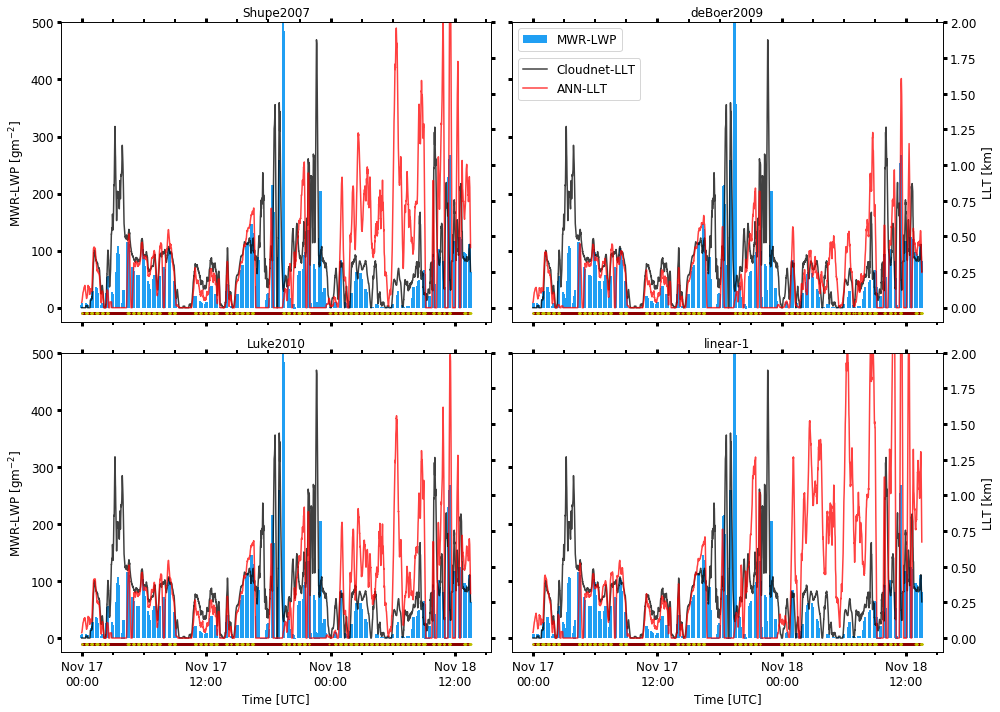

In [22]:

if plot_cloudnet_mwr_lwp:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    
    # loop over the different box thresholds
    for (i, j), (ithresh_name, ithresh_val) in zip(product(range(2), range(2)), lidar_thresh_dict.items()):
        
        # calculate layer thickness for all different categories
        liq_mask = lidar_thresh_dict[ithresh_name]['liquid_mask']
        combi_liq_mask = lidar_thresh_dict[ithresh_name]['combi_liquid_mask']
        classification.update({'combi_liq_mask': combi_liq_mask})
        combi_liquid_mask = wrapper(classification, var_name='combi_liq_mask', var_unit='-')
        sum_ll_thickness = lidar_thresh_dict[ithresh_name]['sum_ll_thickness']
        sum_ll_thickness_smoothed = lidar_thresh_dict[ithresh_name]['sum_ll_thickness_smoothed']

        fig_name = f'CN-mwr-lwp-{time_string}_{exclude_drizzle}_ACCEPT_{ithresh_name}{file_ext}'
        titlestring = f'MWR-LWP versus Cloudnet or ANN liquid layer thickness -- ACCEPT \n' \
                      f' date: {begin_dt:%Y-%m-%d %H:%M:%S} till {end_dt:%Y-%m-%d %H:%M:%S} -- threshold: {ithresh_name}'
        lwp['name'] = 'MWR - liquid water path'
        lwp['system'] = ''
        
        joint = (adiabatic_lwp['mwr_s'] > 0.0) * (adiabatic_lwp[f'{ithresh_name}_s'] > 0.0) * lidar_thresh_dict[ithresh_name]['liquid_mask'].any(axis=0)
        
        #fig, ax = tr.plot_timeseries(lwp, linewidth=3.5, alpha=0.9, **plot_specs)
       
        ax1 = ax[i, j].twinx()
        l1 = ax1.plot(dt_list, sum_cn_ll_thickness_smoothed/1000., color='black', linestyle='-', alpha=0.75, label='Cloudnet-LLT')
        l2 = ax1.plot(dt_list, sum_ll_thickness_smoothed/1000., color='red', linestyle='-', alpha=0.75, label='ANN-LLT')
        
        ax[i, j].set_ylim([-25, 500])
        ax1.set_ylim([-0.1, 2.0])

        load_xy_style(ax=ax[i, j], ylabel=r'MWR-LWP [gm$^{-2}$]')
        load_xy_style(ax=ax1, ylabel=r'LLT [km]')
        ax[i, j] = tr.set_xticks_and_xlabels(ax[i, j], time_extend)
        ax[i, j].set_title(f'{ithresh_name}')
        ax[i, j].tick_params(which='both', right=False)
        
        av_glab = np.full(joint.size, -10)
        ax[i, j].scatter(get_subset(dt_list, ~joint), av_glab[~joint], c='darkred', s=1, label=None)
        ax[i, j].scatter(get_subset(dt_list, joint),  av_glab[joint], c='y', s=1, label=None)
        
        lwp_bar = ax[i, j].bar(dt_list, adiabatic_lwp[f'mwr_s'], width=0.01, color=[0.1254902 , 0.62352941, 0.95294118], label='MWR-LWP')
        if i==0 and j==1:  
            ax[0, 1].legend((lwp_bar,), ('MWR-LWP',), loc='upper left', bbox_to_anchor=(0, 1), prop={'size': plot_specs['label_size'], 'weight': plot_specs['font_weight']})
            ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.9), prop={'size': plot_specs['label_size'], 'weight': plot_specs['font_weight']})

        if j == 0:
            ax1.set_yticklabels([])
            ax1.set_ylabel('')
        if j == 1: 
            ax[i, j].set_ylabel('')
            ax[i, j].set_yticklabels([])
            #ax[i, j].set_yticks([])
        if i == 0: 
            ax[i, j].set_xlabel('')
            ax[i, j].set_xticklabels([])

        logger.info(f'Figure :: {fig_name}')

 
    plt.subplots_adjust(wspace=0.5, hspace=0.02)
    plt.tight_layout(rect=[0, 0, 1., 1.])



fig_name = f'MWR-LWP_LLT_{time_string}_{exclude_drizzle}_ACCEPT{file_ext}'
fig.savefig(fig_name, dpi=dpi)

0.0 501.17725500757837


Figure :: MWR-LWP_adLWP20141116235900-20141118133100_rg0drizzle_ACCEPT.png


0.0 150.26226166446432


Figure :: MWR-LWP_adLWP20141116235900-20141118133100_rg0drizzle_ACCEPT.png


0.0 233.45681406394016


Figure :: MWR-LWP_adLWP20141116235900-20141118133100_rg0drizzle_ACCEPT.png


0.0 506.5870893307175


Figure :: MWR-LWP_adLWP20141116235900-20141118133100_rg0drizzle_ACCEPT.png


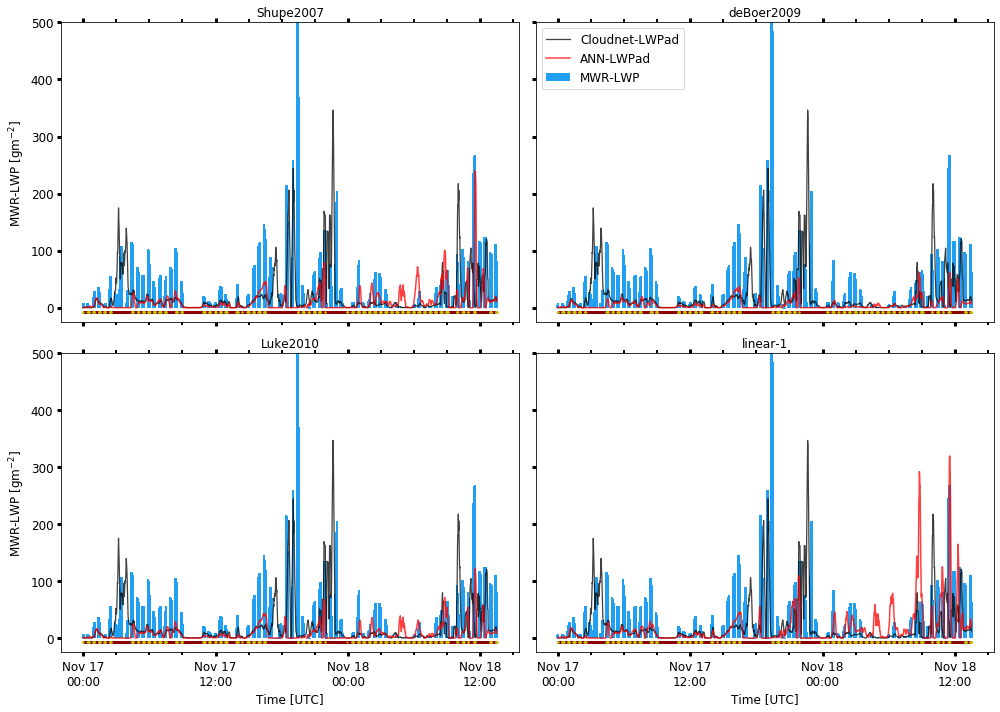

In [25]:
plot_cloudnet_mwr_lwp =True

if plot_cloudnet_mwr_lwp:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    
    # loop over the different box thresholds
    for (i, j), (ithresh_name, ithresh_val) in zip(product(range(2), range(2)), lidar_thresh_dict.items()):
        print(adiabatic_lwp[ithresh_name].min(), adiabatic_lwp[ithresh_name].max())

        adiabatic_lwp[f'{ithresh_name}_s'] = np.convolve(adiabatic_lwp[ithresh_name], box, mode='same')
        
        joint = (adiabatic_lwp['mwr_s'] > 0.0) * (adiabatic_lwp[f'{ithresh_name}_s'] > 0.0) * lidar_thresh_dict[ithresh_name]['liquid_mask'].any(axis=0)
        

        ax[i, j].bar(dt_list, adiabatic_lwp['mwr_s'], width=0.01, color=[0.1254902 , 0.62352941, 0.95294118], label='MWR-LWP')
        ax[i, j].plot(dt_list, adiabatic_lwp['cloudnet_s'], color='black', linewidth=1.25, alpha=0.75, label=f'Cloudnet-LWPad')
        ax[i, j].plot(dt_list, adiabatic_lwp[f'{ithresh_name}_s'], color='red', linewidth=1.5, alpha=0.75, label=f'ANN-LWPad')
        
        av_glab     = np.full(joint.size, -7)
        ax[i, j].scatter(get_subset(dt_list, ~joint), av_glab[~joint], c='darkred', s=1)
        ax[i, j].scatter(get_subset(dt_list, joint),  av_glab[joint], c='y', s=1)
        
        load_xy_style(ax=ax[i, j], ylabel=r'MWR-LWP [gm$^{-2}$]')
        ax[i, j] = tr.set_xticks_and_xlabels(ax[i, j], time_extend)
        ax[i, j].set_title(f'{ithresh_name}')
        ax[i, j].tick_params(which='both', right=False)

        ax[i, j].set_ylim([-25, 500])

        if j == 1: 
            ax[i, j].set_ylabel('')
            ax[i, j].set_yticklabels([])
            #ax[i, j].set_yticks([])
        if i == 0: 
            ax[i, j].set_xlabel('')
            ax[i, j].set_xticklabels([])

        logger.info(f'Figure :: {fig_name}')
        
            
    ax[0, 1].legend(loc='upper left', bbox_to_anchor=(0, 1), prop={'size': plot_specs['label_size'], 'weight': plot_specs['font_weight']})
    plt.subplots_adjust(wspace=0.5, hspace=0.02)
    plt.tight_layout(rect=[0, 0, 1., 1.])


fig_name = f'MWR-LWP_adLWP{time_string}_{exclude_drizzle}_ACCEPT{file_ext}'
fig.savefig(fig_name, dpi=dpi)


In [24]:

for ithresh_name in thresholds:
    
    logger.info(f"  thresh: {ithresh_name:10s}     N_liquid = {np.sum(lidar_thresh_dict[ithresh_name]['liquid_mask'])}")
    
    joint = (adiabatic_lwp['mwr']>0.0) * (adiabatic_lwp[ithresh_name]>0.0) #* lidar_thresh_dict[ithresh_name]['liquid_mask']
    joint_s = (adiabatic_lwp['mwr_s']>0.0) * (adiabatic_lwp[f'{ithresh_name}_s']>0.0) #* lidar_thresh_dict[ithresh_name]['liquid_mask']
    
    corr_coefs[ithresh_name][f"mwr-ad-lwp"]   = corr_(adiabatic_lwp['mwr'][joint],   adiabatic_lwp[ithresh_name][joint])
    corr_coefs[ithresh_name][f"mwr-ad-lwp_s"] = corr_(adiabatic_lwp['mwr_s'][joint_s], adiabatic_lwp[f'{ithresh_name}_s'][joint_s])
    
    logger.info(f'       corr(mwr-lwp, llt) = {corr_coefs[ithresh_name][f"lwp-llt"]:.2f},  {corr_coefs[ithresh_name][f"lwp-llt_s"]:.2f}')
    logger.info(f"    corr(mwr-lwp, ad-lwp) = {corr_coefs[ithresh_name]['mwr-ad-lwp']:.2f},  {corr_coefs[ithresh_name]['mwr-ad-lwp_s']:.2f}")
    logger.info(f"           corr(cbh, llh) = {corr_coefs[ithresh_name]['cbh-llh']:.2f}\n")

                
for ithresh_name in ['cloudnet']:
    
    logger.info(f"  thresh: {ithresh_name:10s}     N_liquid = {np.sum(cloudnet_thresh_dict['liquid_mask'])}")
    
    joint = (adiabatic_lwp['mwr']>0.0) * (adiabatic_lwp[ithresh_name]>0.0) #* cloudnet_thresh_dict['liquid_mask']
    joint_s = (adiabatic_lwp['mwr_s']>0.0) * (adiabatic_lwp[f'{ithresh_name}_s']>0.0) #* cloudnet_thresh_dict['liquid_mask']
    
    corr_coefs[ithresh_name][f"mwr-ad-lwp"]   = corr_(adiabatic_lwp['mwr'][joint],   adiabatic_lwp[ithresh_name][joint])
    corr_coefs[ithresh_name][f"mwr-ad-lwp_s"] = corr_(adiabatic_lwp['mwr_s'][joint_s], adiabatic_lwp[f'{ithresh_name}_s'][joint_s])
    
    logger.info(f'       corr(mwr-lwp, llt) = {corr_coefs[ithresh_name][f"lwp-llt"]:.2f},  {corr_coefs[ithresh_name][f"lwp-llt_s"]:.2f}')
    logger.info(f"    corr(mwr-lwp, ad-lwp) = {corr_coefs[ithresh_name]['mwr-ad-lwp']:.2f},  {corr_coefs[ithresh_name]['mwr-ad-lwp_s']:.2f}")
    logger.info(f"           corr(cbh, llh) = {corr_coefs[ithresh_name]['cbh-llh']:.2f}\n")
    

  thresh: Shupe2007      N_liquid = 50993
       corr(mwr-lwp, llt) = 0.33,  0.33
    corr(mwr-lwp, ad-lwp) = 0.47,  0.33
           corr(cbh, llh) = 0.78

  thresh: deBoer2009     N_liquid = 30682
       corr(mwr-lwp, llt) = 0.47,  0.54
    corr(mwr-lwp, ad-lwp) = 0.55,  0.38
           corr(cbh, llh) = 0.77

  thresh: Luke2010       N_liquid = 41605
       corr(mwr-lwp, llt) = 0.37,  0.39
    corr(mwr-lwp, ad-lwp) = 0.55,  0.34
           corr(cbh, llh) = 0.76

  thresh: linear-1       N_liquid = 63016
       corr(mwr-lwp, llt) = 0.28,  0.28
    corr(mwr-lwp, ad-lwp) = 0.47,  0.34
           corr(cbh, llh) = 0.79

  thresh: cloudnet       N_liquid = 47084
       corr(mwr-lwp, llt) = 0.28,  0.28
    corr(mwr-lwp, ad-lwp) = 0.21,  0.20
           corr(cbh, llh) = 0.92



## 

## 